# 画像処理のテスト

dataフォルダに格納されているdogとcatの2クラスの画像を分類するモデルを作成せよ。

サンプル数

- dog: 250枚
- cat: 250枚

訓練データ: 全体の70%をランダムに（seed=0）

AccuracyがValidationのデータに対して70%得られていること

In [1]:
from glob import glob
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import chainer
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_dir = '../data/'

cat_filepaths = glob(os.path.join(data_dir, 'cat/*.jpg'))
dog_filepaths = glob(os.path.join(data_dir, 'dog/*.jpg'))
len(cat_filepaths), len(dog_filepaths)

(250, 250)

### データの確認

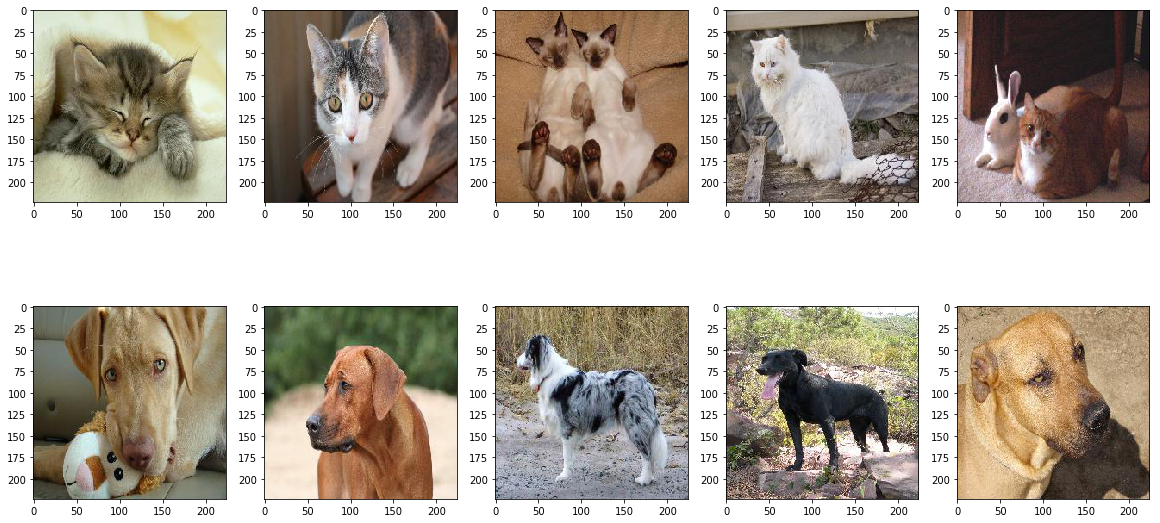

In [3]:
# サンプル的に画像を見てみる
np.random.seed(0)
plt.figure(figsize=(20, 10))
for i in range(5):
    sample_cat = np.random.choice(cat_filepaths)
    sample_img = Image.open(sample_cat)
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_img)
    
    sample_dog = np.random.choice(dog_filepaths)
    sample_img = Image.open(sample_dog)
    plt.subplot(2, 5, i+6)
    plt.imshow(sample_img)

plt.show()

気づいたこと
* 正方形に加工されている様子
* 全身の画像や顔などの一部だけ写ってる画像もある
* うさぎも写っているものもある
* 肉球もある

In [4]:
# 犬猫データの結合
train_label = {
    'cat': 1,
    'dog': 0}

df = pd.DataFrame({
    'file_path': cat_filepaths + dog_filepaths,
})
df['label'] = df['file_path'].str.split('/', expand=True)[2]
df['target'] = df['label'].replace(train_label)
df.shape

(500, 3)

In [5]:
df.head()

,file_path,label,target
0,../data/cat/135.jpg,cat,1
1,../data/cat/262.jpg,cat,1
2,../data/cat/4.jpg,cat,1
3,../data/cat/74.jpg,cat,1
4,../data/cat/130.jpg,cat,1


In [6]:
df.tail()

,file_path,label,target
495,../data/dog/277.jpg,dog,0
496,../data/dog/342.jpg,dog,0
497,../data/dog/177.jpg,dog,0
498,../data/dog/145.jpg,dog,0
499,../data/dog/183.jpg,dog,0


In [7]:
# 画像サイズを調べる
for i, row in df.iterrows():
    img = cv2.imread(row['file_path'])
    df.loc[i, 'height'] = img.shape[0]
    df.loc[i, 'width'] = img.shape[1]
    df.loc[i, 'channel'] = img.shape[2]

In [8]:
df.iloc[np.random.choice(df.index, 5)]

,file_path,label,target,height,width,channel
242,../data/cat/219.jpg,cat,1,224.0,224.0,3.0
292,../data/dog/69.jpg,dog,0,224.0,224.0,3.0
87,../data/cat/257.jpg,cat,1,224.0,224.0,3.0
70,../data/cat/48.jpg,cat,1,224.0,224.0,3.0
472,../data/dog/423.jpg,dog,0,224.0,224.0,3.0


In [9]:
df['height'].unique(), df['width'].unique(), df['channel'].unique()

(array([224.]), array([224.]), array([3.]))

* すべて同じサイズ・チャネル数も同じ画像と確認
* サイズは224x224

### データセットを作る

In [10]:
from chainer.datasets import TupleDataset, split_dataset_random
from chainer.datasets import LabeledImageDataset, TransformDataset
from chainer.iterators import SerialIterator

# seedの固定
import random

def reset_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

reset_seed()

In [11]:
# データセットを作成
dataset = TupleDataset(df['file_path'], df['target'].astype('int32'))
dataset[0][0], dataset[0][1].dtype

#train（モデル学習用）, test（モデル評価用）に、７：３にランダムサンプルして分割
train, test = split_dataset_random(dataset, int(len(dataset)*0.7), seed=0)
len(train), len(test)

(350, 150)

In [12]:
# ちゃんとランダムになってるかチェック
train[0:10]

[('../data/cat/162.jpg', 1),
 ('../data/dog/321.jpg', 0),
 ('../data/dog/296.jpg', 0),
 ('../data/dog/366.jpg', 0),
 ('../data/dog/411.jpg', 0),
 ('../data/cat/99.jpg', 1),
 ('../data/dog/226.jpg', 0),
 ('../data/dog/139.jpg', 0),
 ('../data/cat/16.jpg', 1),
 ('../data/cat/205.jpg', 1)]

In [13]:
# LabeledImageDatasetに格納
train = LabeledImageDataset(train)
test = LabeledImageDataset(test)

In [14]:
train[0][0].shape, train[0][1].shape

((3, 224, 224), ())

In [15]:
train[0][0].dtype, train[0][1].dtype

(dtype('float32'), dtype('int32'))

## モデル設計・学習・評価

In [16]:
from chainer.optimizers import Adam
import chainer.links as L
import chainer.functions as F
from chainer.training import StandardUpdater, Trainer
from chainer.training.extensions import Evaluator, LogReport, PrintReport

In [17]:
def model_evaluation(nn, epoch=10, batch_size=16, use_gpu=True):
    # Model Instance
    model = L.Classifier(nn)
    
    if use_gpu:
        device = 0
        model.to_gpu(device)
    else:
        device = -1
    
    # ミニバッチのインスタンスを作成
    train_iter = SerialIterator(train, batch_size)
    test_iter = SerialIterator(test, batch_size, repeat=False, shuffle=False)
    
    # Set Lerning
    optimizer = Adam()
    optimizer.setup(model)
    
    updater = StandardUpdater(train_iter, optimizer, device=device)

    trainer = Trainer(updater, (epoch, 'epoch'), out='result/cat_dog')
    trainer.extend(Evaluator(test_iter, model, device=device))
    trainer.extend(LogReport(trigger=(1, 'epoch')))
    trainer.extend(PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 
                                'main/loss', 'validation/main/loss', 'elapsed_time']), 
                   trigger=(1, 'epoch'))
    
    trainer.run()
    
    if use_gpu:
        model.to_cpu()

    return model
        
def visualize_result():
    with open('./result/cat_dog/log') as f:
        result = pd.DataFrame(json.load(f))
        
    print('Elapsed time: %d sec' % result.iloc[-1]['elapsed_time'])
    print('Validation accuracy:', result.iloc[-1]['validation/main/accuracy'])
    result[['main/accuracy', 'validation/main/accuracy']].plot()
    return result

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.482955       0.504167                  12048.8     5157.26               1.93316       
2           0.556818       0.602083                  2270.18     1248.67               3.85565       
3           0.670455       0.6                       682.009     726.443               5.76426       
4           0.710227       0.577083                  340.017     668.326               7.67666       
5           0.818182       0.708333                  119.256     271.888               9.5922        
6           0.838068       0.666667                  82.4894     260.874               11.5188       
7           0.903409       0.647917                  47.3063     310.093               13.4302       
8           0.928571       0.679167                  24.6161     230.992               15.2892       
9           0.960227       0.666667                  8.02807     291.746            

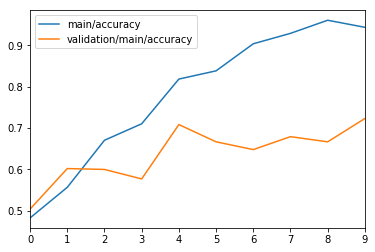

In [23]:
setting = {
    'epoch': 10,
    'batch_size': 16,
    'use_gpu': True
}


class CNN(chainer.Chain):
    def __init__(self, n_mid=100, n_out=2):
        super().__init__()
        with self.init_scope():
            self.cnv1 = L.Convolution2D(in_channels=3, 
                                        out_channels=16, 
                                        ksize=3,
                                        stride=1,
                                        pad=1)
            self.fc1 = L.Linear(None, n_mid)
            self.fco = L.Linear(None, n_out)
            
    def __call__(self, x):
        h = self.cnv1(x)
        h = F.relu(h)
        h = F.max_pooling_2d(h, 3, 3)
        h = self.fc1(h)
        h = self.fco(h)
        return h

network = CNN()
model = model_evaluation(network, setting['epoch'], setting['batch_size'], setting['use_gpu'])
result = visualize_result()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.548295       0.652083                  3181.39     399.722               1.91094       
2           0.698864       0.604167                  229.203     345.976               3.80507       
3           0.769886       0.664583                  97.7538     202.436               5.69734       
4           0.880682       0.727083                  20.1735     145.261               7.58943       
5           0.931818       0.654167                  9.15808     174.697               9.49411       
6           0.914773       0.660417                  9.00373     157.903               11.3956       
7           0.889205       0.666667                  25.6747     133.679               13.3255       
8           0.91369        0.666667                  19.9369     190.348               15.1562       
9           0.971591       0.729167                  1.08277     151.968            

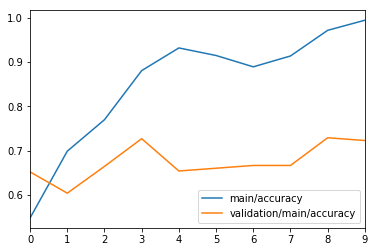

In [24]:
setting = {
    'epoch': 10,
    'batch_size': 16,
    'use_gpu': True
}

class CNN(chainer.Chain):
    def __init__(self, n_mid=100, n_out=2):
        super().__init__()
        with self.init_scope():
            self.cnv1 = L.Convolution2D(in_channels=3, 
                                        out_channels=16, 
                                        ksize=3,
                                        stride=1,
                                        pad=1)
            self.fc1 = L.Linear(None, n_mid)
            self.fco = L.Linear(None, n_out)
            
    def __call__(self, x):
        h = self.cnv1(x)
        h = F.relu(h)
        h = F.max_pooling_2d(h, 3, 3)
        h = self.fc1(h)
        h = self.fco(h)
        return h

network = CNN()
model = model_evaluation(network, setting['epoch'], setting['batch_size'], setting['use_gpu'])
result = visualize_result()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.56           0.593333                  159.962     4.83005               3.61807       
2           0.837143       0.62                      0.730552    5.82701               7.15455       
3           0.96           0.6                       0.176766    6.04298               10.771        
4           0.968571       0.6                       0.0767008   6.24088               14.3706       
5           0.98           0.606667                  0.0535593   6.36323               17.9624       
6           0.98           0.613333                  0.0400872   6.76958               21.5312       
7           0.991429       0.58                      0.0287455   7.12621               25.0578       
8           0.991429       0.6                       0.0192867   7.45797               28.5692       
9           0.997143       0.58                      0.0136942   7.74584            

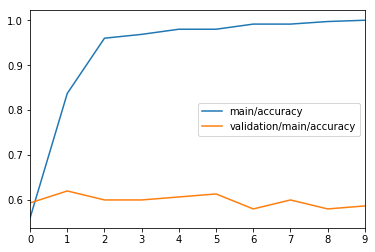

In [19]:
setting = {
    'epoch': 10,
    'batch_size': 16,
    'use_gpu': True
}

class MyNetWork(chainer.Chain):
    def __init__(self, n_mid=100, n_out=2):
        super().__init__()
        with self.init_scope():
            self.cnv1 = L.Convolution2D(in_channels=3, 
                                        out_channels=16, 
                                        ksize=3,
                                        stride=1,
                                        pad=1)
            self.cnv2 = L.Convolution2D(in_channels=None, 
                                        out_channels=16, 
                                        ksize=3,
                                        stride=1,
                                        pad=1)
            self.fc1 = L.Linear(None, n_mid)
            self.fco = L.Linear(None, n_out)
            
    def __call__(self, x):
        h = self.cnv1(x)
        h = self.cnv2(h)
        h = F.max_pooling_2d(h, 3, 3)
        h = F.relu(h)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fco(h)
        return h

network = MyNetWork()
model = model_evaluation(network, setting['epoch'], setting['use_gpu'])
result = visualize_result()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.56           0.633333                  137.448     6.2696                4.53359       
2           0.862857       0.586667                  0.899064    5.1803                8.94128       
3           0.968571       0.64                      0.0936747   5.82103               13.3553       
4           0.982857       0.593333                  0.0759318   6.25335               17.7689       
5           0.991429       0.606667                  0.0379654   7.11576               22.1746       
6           0.985714       0.593333                  0.0299813   7.74341               26.5745       
7           0.991429       0.593333                  0.0198447   8.35107               30.9877       
8           0.994286       0.6                       0.0152312   9.25959               35.4075       
9           1              0.606667                  0.00920898  9.85728            

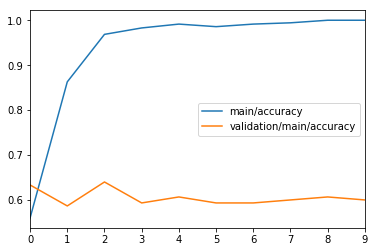

In [65]:
setting = {
    'epoch': 10,
    'batch_size': 16,
    'use_gpu': True
}

class MyNetWork(chainer.Chain):
    def __init__(self):
        super().__init__()
        with self.init_scope():
            self.cnv1 = L.Convolution2D(in_channels=3, 
                                        out_channels=16, 
                                        ksize=3,
                                        stride=1,
                                        pad=1)
            self.cnv2 = L.Convolution2D(in_channels=None, 
                                        out_channels=16, 
                                        ksize=3,
                                        stride=1,
                                        pad=1)
            self.fc1 = L.Linear(None, 256)
            self.fco = L.Linear(None, 2)
            
    def __call__(self, x):
        h = self.cnv1(x)
        h = self.cnv2(h)
        h = F.max_pooling_2d(h, 3, 3)
        h = F.relu(h)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fco(h)
        return h

network = MyNetWork()
model = model_evaluation(network, setting['epoch'], setting['use_gpu'])
result = visualize_result()